In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib import style
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

style.use("ggplot")
conn = sqlite3.connect(r"C:\Users\oisin\Code\CS185CProject\FPA_FOD_20170508.sqlite")

In [2]:
df = pd.read_sql_query(''' SELECT * FROM classifed_weather_data ''', conn)

In [3]:
cdf = df.drop(['level_0', 'index', 'stn', 'wban', 'date', 'sndp'] + list(df.filter(regex='count_')) + list(df.filter(regex='flag')), axis=1).replace([9999.9, 999.9], 0)

In [4]:
cdf = cdf.apply(pd.to_numeric, errors='coerce')

In [5]:
fdf = cdf[cdf['isFire'] == 1]
ndf = cdf[cdf['isFire'] == 0]

In [6]:
b = fdf

In [7]:
mean = np.mean(b, axis=0)
At = b - mean
A = At.transpose()

In [8]:
Y = 1/b.shape[0] * A

In [9]:
U, S, V = LA.svd(Y, full_matrices=True)

In [10]:
U.shape

(18, 18)

In [11]:
S.shape, S

((18,), array([1.19280107e+01, 7.93783127e+00, 1.53468067e+00, 5.95217563e-01,
        4.37528045e-01, 2.77598099e-01, 2.39838401e-01, 2.13228496e-01,
        1.56634903e-01, 8.97974190e-02, 5.02092987e-02, 4.43344832e-03,
        3.31632288e-03, 1.77321767e-03, 1.18091849e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]))

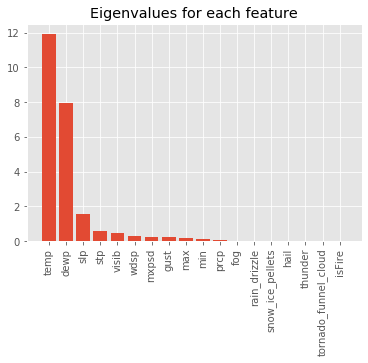

In [12]:
ypos = np.arange(len(fdf.columns))
plt.bar(ypos, S)
plt.xticks(ypos, fdf.columns, rotation='90')
plt.title("Eigenvalues for each feature")
plt.show()

In [13]:
important_cols = fdf.columns[np.where(S > 1)]
important_cols

Index(['temp', 'dewp', 'slp'], dtype='object')

In [14]:
test_cdf = pd.concat([fdf.sample(n=2000, random_state=1), ndf.sample(n=98000, random_state=1)])

In [15]:
X = test_cdf[important_cols].values
Y = test_cdf['isFire'].values

In [16]:
scaler = StandardScaler()

In [17]:
X = scaler.fit_transform(X)

In [18]:
clf = LinearSVC(random_state=1, max_iter=500000)
clf.fit(X, Y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [19]:
Xt = X.transpose()

In [20]:
clf.coef_

array([[ 0.06147369, -0.0482488 , -0.00775867]])

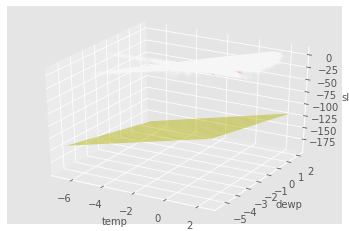

In [21]:
fig = plt.figure()
ax = plt.axes(projection="3d")
color = ['white' if c == 0 else 'red' for c in Y]
ax.scatter(Xt[0], Xt[1], Xt[2], c=color, alpha=0.1)

ax.set_xlabel(important_cols[0], fontsize = 10)
ax.set_ylabel(important_cols[1], fontsize = 10)
ax.set_zlabel(important_cols[2], fontsize = 10)

C = lambda x,y: (-clf.intercept_[0] - clf.coef_[0][0] * x - clf.coef_[0][1] * y) / clf.coef_[0][2]
A,B = np.meshgrid(np.linspace(min(Xt[0]),max(Xt[0]),20),np.linspace(min(Xt[1]),max(Xt[1]),20))
ax.plot_surface(A, B, C(A,B), color='yellow', alpha=0.5)
plt.show()

### Testing Accuracy of SVM

In [22]:
import sklearn.metrics as metrics

In [23]:
test_data = pd.concat([fdf.sample(n=1000, random_state=3), ndf.sample(n=5000, random_state=3)])

In [24]:
y_test = test_data['isFire']
x_test = test_data[important_cols].values

In [25]:
prediction = clf.predict(x_test)
prediction

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [29]:
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      5000
           1       0.24      0.45      0.31      1000

    accuracy                           0.68      6000
   macro avg       0.55      0.58      0.55      6000
weighted avg       0.76      0.68      0.71      6000



In [26]:
average_precision = metrics.average_precision_score(y_test, prediction)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.20


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.20')

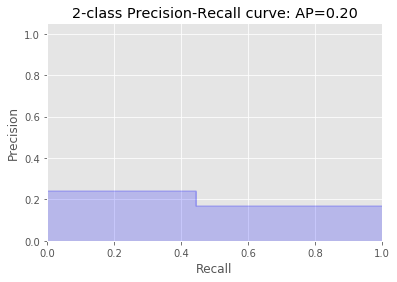

In [27]:
from inspect import signature

precision, recall, _ = metrics.precision_recall_curve(y_test, prediction)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))